# Project: Evaluation of neural network architectures on MNIST datasets

Group Members : Yidong HUANG - yidong.huang@etu.univ-grenoble-alpes.fr , Simon ROBER - simon.rober@grenoble-inp.org, Marck-Edward KEMEH - insert mail

#### ABOUT
The MNIST dataset is a large database of handwritten digits used in many forms of image processing.
This dataset contains 60,000 training images and 10,000 test images. Our aim is to design some neural 
networks that can recognise these hand-written digits. our projects will be based on two different networks
for this task.                   

In [9]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.metrics import roc_curve

We begin by importing the MNIST dataset. The data set is predefined in a trainingset of 60000 training images and another set for testing of 10000 testing images. We use this predefined split in all our experiments. Furthermore we never mix both sets! We then normalize the test set and training set by dividing with 255 so that the values can be between 0 and 1.
Because we will be working with convolutional neural network, we need to change the original shape of the MNIST dataset which is (60000, 28, 28) to that of the convolutional neural network (60000, 28, 28, 1).
This section is just to prepare our dataset for the network.

In [10]:
# dividing dataset into train and test set, also reshaping dataset to fit input of network
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
print('shape before adding dimension is :' ,x_train.shape)
x_train, x_test = np.expand_dims(x_train, axis= -1), np.expand_dims(x_test, axis = -1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print ('shape after adding dimension is :' ,x_train.shape)

shape before adding dimension is : (60000, 28, 28)
shape after adding dimension is : (60000, 28, 28, 1)


## First Model
At the start of the project we started to play around with different models. This first model was our initial result. The model is a simple network with one convolutional layer, a flattening layer (arranges the incomming images into one row), max pooling, and it ends with a fully connected layer with the softmax activation function. At each stage we introduce functions in order to reuse at much code for the later models.

First we define the model itself with its architecture:


In [11]:
#first simple model

model1 = keras.Sequential()
model1.add(layers.Input(shape = (28,28,1)))
model1.add(layers.Conv2D(32, (3,3), padding ='valid', activation = 'relu'))
model1.add(layers.MaxPool2D((2,2), (2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation = 'softmax'))
model1.summary()
model1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


We now train out model with the training set. For each epoch, we can see that the loss decreases, which tells us the model is actually improving on the learning.

In [12]:
#training
model1.fit(x_train, y_train, epochs = 4)

Epoch 1/4
60000/60000 [==============================] - 22s 366us/sample - loss: 0.2148 - acc: 0.9389
Epoch 2/4
60000/60000 [==============================] - 21s 347us/sample - loss: 0.0792 - acc: 0.9768
Epoch 3/4
60000/60000 [==============================] - 22s 368us/sample - loss: 0.0597 - acc: 0.9826
Epoch 4/4
60000/60000 [==============================] - 23s 384us/sample - loss: 0.0491 - acc: 0.9855


Next we use the accuracy to determine how well our classifier classifies on the test set to make sure we are not over fitting.


In [13]:
def accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("test loss is : {0} - test accuracy is : {1}".format(test_loss, test_acc))

    
# Accuracy:
accuracy(model1, x_test, y_test)

10000/10000 [==============================] - 1s 146us/sample - loss: 0.0531 - acc: 0.9822
test loss is : 0.05310244230637327 - test accuracy is : 0.982200026512146


We implement the ROC curve and Precision-Recall curve to view the performance of our model on the test set

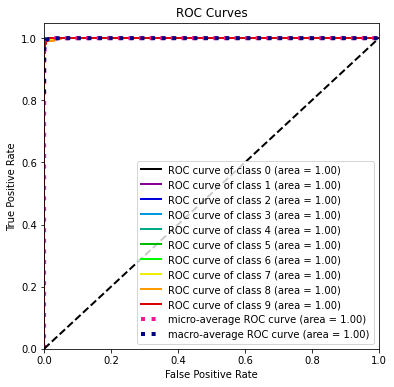

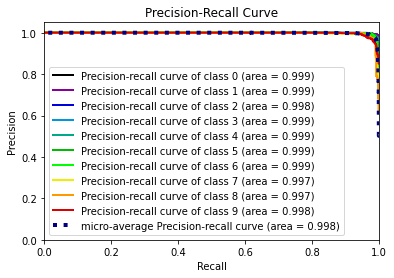

In [20]:
def roc_curve(model, x_test, y_test):
    y_true = y_test # Given ground truth
    y_probas = model.predict(x_test)
    skplt.metrics.plot_roc(y_true, y_probas, figsize=(6,6))     # https://scikit-plot.readthedocs.io/en/stable/metrics.html
    plt.show()

# ROC:
roc_curve(model1, x_test, y_test)

def precision_recall(model, x_test, y_test):
    y_probas = model.predict(x_test)
    skplt.metrics.plot_precision_recall(y_test, y_probas)
    plt.show()
    
# Precision-Recall:
precision_recall(model1, x_test, y_test)

Now a few words on these curves. We see that the model performs very well, since the accuracy is close to 100% and since the roc curve for each class fully covers the area. The same can be said about the precision recall curve: every class almost has an full area. Because the model performs so well, it is hard to make any statements about variations in performance of the model based on these two curves. They do not give a lot of precision, especially with the bare eye. Yet both looking at the curve and at the area's per class we see that the precion-recall curve is more precise then the roc curve. Hence we will not use these performance evaluation often, but we will focus on the accuarcy.

## Second Model
After playing around with the first model, we created a baseline network to explore the efffect of variation of the parameters and hyperparameters. This second model follows the LeNet architecture, this means we start out with a convolutional layer, followed by average pooling, again followed by a second convolutional layer, again with a second average pooling layer, then there is a flatten layer, followed by three fully connected layers. The activation function is relu and the kernel size is a 3 by 3. At each layer the input image become smaller untillit is reduced to one value which defined the class.

Again we first define the network, train it and see how it performs in terms of accuracy, roc curve and precision-recall curve. Notice how we reuse a lot of function defined in the first mode!

In [15]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

model2.fit(x_train, y_train, epochs = 4)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

10000/10000 [==============================] - 2s 161us/sample - loss: 0.0443 - acc: 0.9853
test loss is : 0.044346522647346134 - test accuracy is : 0.9853000044822693


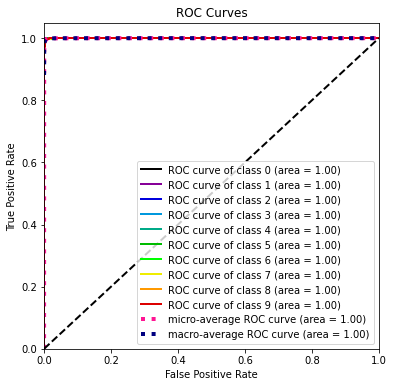

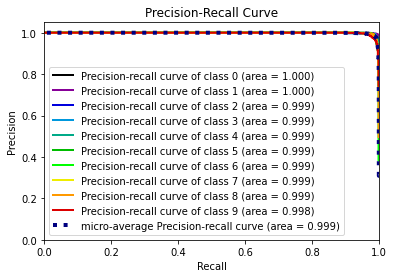

In [16]:
accuracy(model2, x_test, y_test)
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

Again the model performs really well with an accuracy of ** insert ** and an almost perfect roc and precision-recall curve. In the next section we will look into the parameters in a more systematic manner. We will build on the second model described above and alter one parameter everytime.

#### Comparison model one and model two 

** TODO Remove this section based on feedback mail **

At the default learning learning rate and basic definitions of each models, model 1 learns in a very short time and more accurately than model 2. model1 learns at an average ETA of 30s per epoch while model2 learns at an average ETA of 137s per epoch

## Variations on parameters and hyperparameters on top of the second model

### Learning Rate

By default the learning rate of the second model with Adam is 0.001. Lets increase and decease the learning rate slightly to see what the effect is. Note that we only alter one parameter of the second model, not more.

Epoch 1/4
60000/60000 [==============================] - 21s 354us/sample - loss: 0.1547 - acc: 0.9539
Epoch 2/4
60000/60000 [==============================] - 21s 342us/sample - loss: 0.0838 - acc: 0.9766
Epoch 3/4
60000/60000 [==============================] - 18s 298us/sample - loss: 0.0721 - acc: 0.9812
Epoch 4/4
10000/10000 [==============================] - 2s 153us/sample - loss: 0.1006 - acc: 0.9834
test loss is : 0.10059633931327244 - test accuracy is : 0.9833999872207642


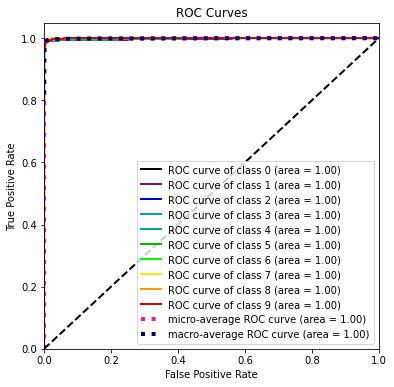

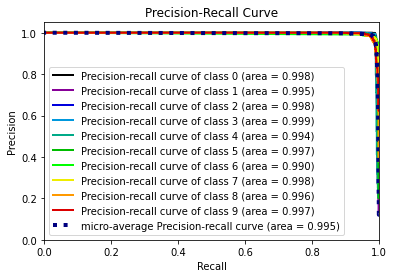

In [21]:
model2_increase_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_increase_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2_increase_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_increase_lr, x_test, y_test)
roc_curve(model2_increase_lr, x_test, y_test)
precision_recall(model2_increase_lr, x_test, y_test)

Epoch 1/4
60000/60000 [==============================] - 18s 303us/sample - loss: 0.7124 - acc: 0.8027
Epoch 2/4
60000/60000 [==============================] - 20s 330us/sample - loss: 0.2796 - acc: 0.9185
Epoch 3/4
60000/60000 [==============================] - 19s 319us/sample - loss: 0.2075 - acc: 0.9389
Epoch 4/4
10000/10000 [==============================] - 2s 157us/sample - loss: 0.1241 - acc: 0.9637
test loss is : 0.12413132668435574 - test accuracy is : 0.963699996471405


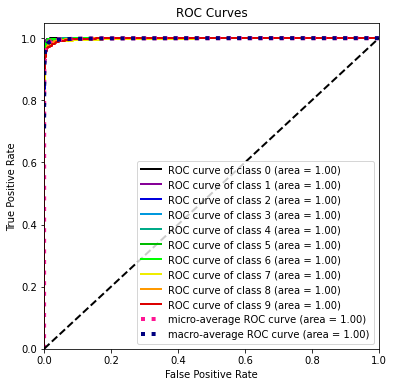

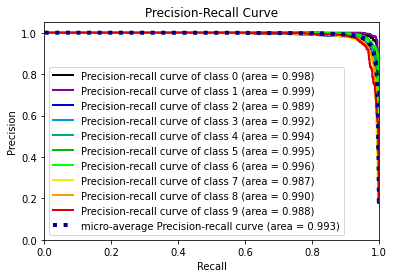

In [22]:
model2_decrease_lr = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2_decrease_lr.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2_decrease_lr.fit(x_train, y_train, epochs = 4)

accuracy(model2_decrease_lr, x_test, y_test)
roc_curve(model2_decrease_lr, x_test, y_test)
precision_recall(model2_decrease_lr, x_test, y_test)

The vanilla second model had an accuracy of about ** 0.9875 **. By increasing the learning rate times 10 the accuracy  drops slightly to about ** 0.9839 **. When decreasing the learning rate through a division of 10 the accuracy also drops, but now even worse to about ** 0.9646 **.

Let us take a look at the different curves. The vanilla version had an almost perfect precision-recall curve, where half of the labels were labeled correctly all the time and the other labels ** 99%** of the times. Yet both increasing and decreasing the learning rate deteriorates the good results by serveral percentages. Here again the decreasing model performs worse then the increasing model. All these difference are very small, so it remains hard to draw any hard conclusions.

Now the Roc curve is not precise enough to show any difference between the models. Hence we cannot draw any conclusions out of it.

When the learning rate is too large, then the algorithm might overshoot its goal, but when the learning rate is too small it might never reach the local minimum (or at least take to much time). Our initial learning rate seems to lie in the desired interval, since increasing or decreasing the learning rare reduces performance. The interval is still quite large: from 0.01 to 0.0001. An imporovement to the model would be to further narrow down this interval to optimise the choice for the learning rate.

### Batch Size

Batch size describe the number of datapoints used in gradient descent, a larger batch size can help you train the model more quickly however at the cost of accuracy. A smaller batch size causes more noise but can reduce generalization error thus have a higher accuracy. Another adventage is that when using GPU, smaller batch size can allow paralle execution since a smaller batch can fit easier in the memory unit.

In [11]:

#batch size is defaut to 32

model2_batch_size3 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size3.summary()
model2_batch_size3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size3.fit(x_train, y_train, batch_size=8, epochs = 4)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_6 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_11 (Dense)             (None, 84)               

In [12]:
model2_batch_size2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size2.summary()
model2_batch_size2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size2.fit(x_train, y_train, batch_size=16, epochs = 4)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_8 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_9 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_14 (Dense)             (None, 84)               

In [13]:
model2_batch_size = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size.summary()
model2_batch_size.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size.fit(x_train, y_train, batch_size=64, epochs = 4)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_10 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

In [14]:
model2_batch_size4 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_batch_size4.summary()
model2_batch_size4.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_batch_size4.fit(x_train, y_train, batch_size=128, epochs = 4)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_12 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_13 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_20 (Dense)             (None, 84)               

### Number of epochs

An epoch refers to one full cycle through the training data. Until this point we have been training with four epochs. This means that the classifier looks at every training example four times in total to train the network. As seen above when fitting the network, we get the **following output**:

```
Epoch 1/4
60000/60000 [==============================] - 20s 338us/sample - loss: 0.2497 - acc: 0.9249
Epoch 2/4
60000/60000 [==============================] - 19s 311us/sample - loss: 0.0817 - acc: 0.9747
Epoch 3/4
60000/60000 [==============================] - 21s 343us/sample - loss: 0.0558 - acc: 0.9823
Epoch 4/4
60000/60000 [==============================] - 20s 334us/sample - loss: 0.0430 - acc: 0.9865
```


Notice how each epoch requires about the same amount of time, but the more epochs you use, the more time it requires to train the network. Also notice how the loss decreases and the accuracy increases with each extra epoch. This reveals a certain trade-off; accuracy or shorter training time. Of course we cannot keep increasing the amount of epochs for ever and expect an continuing increase of the accuracy. At a ceratain point the loss will start to increase because of overfitting. Let us look for the amount of epochs where the loss starts to rise again. This is the optimal in terms of loss, since it is the local minimum.

Now to save you the time of running the below 15 epochs, **the results will be displayed after the code**.

In [15]:
model2_epochs = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


model2_epochs.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_epochs.fit(x_train, y_train, epochs = 15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2233 - accuracy: 0.9338
Epoch 2/15
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0744 - accuracy: 0.9771
Epoch 3/15
60000/60000 [==============================] - 9s 158us/sample - loss: 0.0547 - accuracy: 0.9832
Epoch 4/15
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0420 - accuracy: 0.9869
Epoch 5/15
60000/60000 [==============================] - 9s 153us/sample - loss: 0.0354 - accuracy: 0.9884
Epoch 6/15
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0291 - accuracy: 0.9908
Epoch 7/15
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0247 - accuracy: 0.9923
Epoch 8/15
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0215 - accuracy: 0.9933
Epoch 9/15
60000/60000 [==============================] - 9s 151us/sample - loss: 0.0192 - accuracy: 0.9935
Epoc

```
Epoch 1/30
60000/60000 [==============================] - 26s 438us/sample - loss: 0.2179 - acc: 0.9363
Epoch 2/30
60000/60000 [==============================] - 23s 390us/sample - loss: 0.0717 - acc: 0.9779
Epoch 3/30
60000/60000 [==============================] - 24s 396us/sample - loss: 0.0518 - acc: 0.9840
Epoch 4/30
60000/60000 [==============================] - 24s 401us/sample - loss: 0.0416 - acc: 0.9869
Epoch 5/30
60000/60000 [==============================] - 29s 483us/sample - loss: 0.0340 - acc: 0.9895
Epoch 6/30
60000/60000 [==============================] - 27s 456us/sample - loss: 0.0283 - acc: 0.9912
Epoch 7/30
60000/60000 [==============================] - 28s 460us/sample - loss: 0.0229 - acc: 0.9926
Epoch 8/30
60000/60000 [==============================] - 28s 468us/sample - loss: 0.0195 - acc: 0.9941
Epoch 9/30
60000/60000 [==============================] - 34s 560us/sample - loss: 0.0179 - acc: 0.9942
Epoch 10/30
60000/60000 [==============================] - 39s 643us/sample - loss: 0.0151 - acc: 0.9953
Epoch 11/30
60000/60000 [==============================] - 33s 549us/sample - loss: 0.0143 - acc: 0.9953
Epoch 12/30
60000/60000 [==============================] - 33s 554us/sample - loss: 0.0106 - acc: 0.9964
Epoch 13/30
60000/60000 [==============================] - 29s 490us/sample - loss: 0.0108 - acc: 0.9963
```

After 12 epochs the loss show a small increase. So the optimal amount of epochs for this CNN is around 12. Now when appling more epochs we see that the loss starts to fluctuate and decreases gently. This is expected, but overfitting  can potentially become a issue for some model. We can see that the gap between traning and testing accurecy is larger here (around 0.006) compares to the original model (around o.oo1).

Note that running this code again might result in some different values. Yet the same reasoning holds.

Finally, you can see just below here that the accuarcy is much better when appling more epochs. It has increased from ** insert ** to ** insert **.

In [29]:
accuracy(model2_epochs, x_test, y_test)

10000/10000 [==============================] - 1s 67us/sample - loss: 0.0420 - accuracy: 0.9900
test loss is : 0.04204701000508072 - test accuracy is : 0.9900000095367432


### Kernel size

In this section, we would like to see the results of varied kernel sizes on our model. 
As seen from the roiginial second model with kernel sizes (3, 3) at each layer, we get an accuracy of 0.984 on the test set as defined below:

    10000/10000 [==============================] - 2s 159us/sample - loss: 0.0459 - acc: 0.9841
    test loss is : 0.04586207606535172 - test accuracy is : 0.9840999841690063

We set the first layer of the network with kernel size of (5, 5) and the second remains same at (3, 3) and we get an accuracy of 0.983 on the test set as shown below. This is an improvement on the original model with both kernels at (3, 3).
    
    10000/10000 [==============================] - 3s 307us/sample - loss: 0.0525 - accuracy: 0.9835
    test loss is : 0.05253282631125767 - test accuracy is : 0.9835000038146973
    
Changing the kernal size of first layer to (6, 6) gives an accuracy of  0.986 and (2, 2) gives an accuracy of 0.986.

    10000/10000 [==============================] - 3s 339us/sample - loss: 0.0408 - accuracy: 0.9862
    test loss is : 0.0407773371128249 - test accuracy is : 0.9861999750137329
    

In [16]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 191us/sample - loss: 0.2425 - accuracy: 0.9269
Epoch 2/4
60000/60000 [==============================] - 11s 179us/sample - loss: 0.0786 - accuracy: 0.9756
Epoch 3/4
60000/60000 [==============================] - 11s 180us/sample - loss: 0.0548 - accuracy: 0.9827
Epoch 4/4
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0371 - accuracy: 0.9888
test loss is : 0.03708968871569377 - test accuracy is : 0.9887999892234802


we can see changing the kernel size alone does not significantly increase the accuracy of the model
###### NOTE 
rerunning the above code might give different results

### Loss functions
throughout our work, we have used the sparse_categorical_crossentropy loss on our model

Still experimenting on our second model, we woud like to see the effects of different loss functions.
#### Mean Squared Error (MSE)- 
MSE measures the average squared difference between the estimated values and the actual values.
With MSE, it is a requirement that the output layer has just one node and also he linear activation function is used in this respect

In [17]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=1, activation = 'linear')   
    ])


#model2.summary()

model2.compile(optimizer = "adam", loss = "mse",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 189us/sample - loss: 1.9724 - accuracy: 0.1638
Epoch 2/4
60000/60000 [==============================] - 11s 184us/sample - loss: 0.6406 - accuracy: 0.1903
Epoch 3/4
60000/60000 [==============================] - 11s 184us/sample - loss: 0.4388 - accuracy: 0.1990
Epoch 4/4
10000/10000 [==============================] - 1s 63us/sample - loss: 0.3482 - accuracy: 0.2022
test loss is : 0.3482273269891739 - test accuracy is : 0.2021999955177307


Choosing the MSE as the loss function is not the best choice. We have 10 different
numbers to predict where each is assigned to a neuron on the output layer. But MSE 
requires only one neuron on the output layer which is good for predicting just one type of value.
we can clearly see from above that this performs poorly for our type of data. 
Also since MSE loss is for regression, it cannot be used for this classification model.


#### categorical crossentropy Loss
to use this loss function, we need to hot encode one of the target set.

This is to ensure that each example has an expected probability of 1.0 for the actual class value and an expected probability of 0.0 for all other class values. The efficiency of this loss is almost the same as sparse_categorical_crossentropy.

In [18]:
from tensorflow.keras.utils import to_categorical

#hot encoding
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')   
    ])

#y_binary = to_categorical(y_train)
#x_binary = to_categorical(x_train)
#model2.summary()

model2.compile(optimizer = "adam", loss = "categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train_cat, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test_cat)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 13s 210us/sample - loss: 0.1994 - accuracy: 0.9414
Epoch 2/4
60000/60000 [==============================] - 12s 207us/sample - loss: 0.0698 - accuracy: 0.9784
Epoch 3/4
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0514 - accuracy: 0.9842
Epoch 4/4
10000/10000 [==============================] - 1s 67us/sample - loss: 0.0416 - accuracy: 0.9852
test loss is : 0.04157914041795302 - test accuracy is : 0.9851999878883362


this even gives us a higher acuracy at 0.99 in some cases.


#### kullback leibler divergence Loss

In [19]:
from keras.utils import to_categorical

model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')   
    ])


#model2.summary()

model2.compile(optimizer = "adam", loss = "kullback_leibler_divergence",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train_cat, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test_cat)

Train on 60000 samples
Epoch 1/4


Using TensorFlow backend.


60000/60000 [==============================] - 12s 208us/sample - loss: 0.2094 - accuracy: 0.9362
Epoch 2/4
60000/60000 [==============================] - 12s 208us/sample - loss: 0.0689 - accuracy: 0.9791
Epoch 3/4
60000/60000 [==============================] - 12s 199us/sample - loss: 0.0490 - accuracy: 0.9848
Epoch 4/4
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0388 - accuracy: 0.9874
test loss is : 0.03881394610721618 - test accuracy is : 0.9873999953269958


#### Types of Pooling

According to the lecture notes pooling is a form of down-sampling that partitions the image into non-overlapping regions and computes a representation value for each region. Now there are several ways to achieve this, we will limmit ourselfves to the difference between average pooling and max pooling, since they are the most used. In the vanilla model we already experimented with average pooling, so now we will explore max pooling:

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_38 (Dense)             (None, 84)              

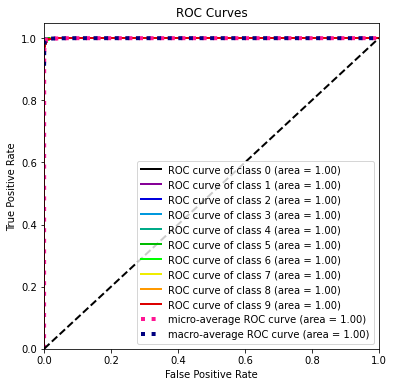

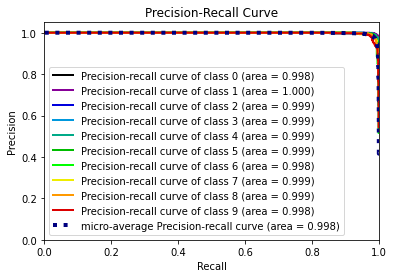

In [20]:
model2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPool2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model2.fit(x_train, y_train, epochs = 4)

accuracy(model2, x_test, y_test)
roc_curve(model2, x_test, y_test)
precision_recall(model2, x_test, y_test)

When comparing both types of pooling, we notice that they perform about equally well in term of accuracy, roc and percision recall. 

### Non-liner activation function

The activation function we used in our base model of LeNet is relu and softmax, we are going to play with different non-linear activation functions on different layers in the section below. We did not touch the softmax activation function for the last layer since softmax is an approximation for the Gaussian connections


#### TANH


TANH is used in the original LeNet, but in general relu give us a better performance. This is the reason why we used relu in our netkwork in the first place. We can see this difference by the comparison below:

In [21]:
#### On convolutional layers
model2_tanh_cov1 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_tanh_cov1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])


model2_tanh_cov1.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_tanh_cov1, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 189us/sample - loss: 0.2459 - accuracy: 0.9254
Epoch 2/4
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0953 - accuracy: 0.9707
Epoch 3/4
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0685 - accuracy: 0.9782
Epoch 4/4
10000/10000 [==============================] - 1s 72us/sample - loss: 0.0566 - accuracy: 0.9812
test loss is : 0.05662589471100364 - test accuracy is : 0.9811999797821045


In [22]:
#### On dense layers
model2_tanh_cov2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='tanh'),
        layers.Dense(units=84, activation='tanh'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_tanh_cov2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_tanh_cov2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_tanh_cov2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 9s 157us/sample - loss: 0.2143 - accuracy: 0.9365
Epoch 2/4
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0721 - accuracy: 0.9776
Epoch 3/4
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0521 - accuracy: 0.9838
Epoch 4/4
10000/10000 [==============================] - 1s 69us/sample - loss: 0.0508 - accuracy: 0.9841
test loss is : 0.05083518260112032 - test accuracy is : 0.9840999841690063


In [23]:
# On both convolutional and dense layers
model2_tanh_cov3 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='tanh'),
        layers.Dense(units=84, activation='tanh'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_tanh_cov3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_tanh_cov3.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_tanh_cov3, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 183us/sample - loss: 0.2463 - accuracy: 0.9254
Epoch 2/4
60000/60000 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - 10s 171us/sample - loss: 0.0923 - accuracy: 0.9717
Epoch 3/4
60000/60000 [==============================] - 10s 171us/sample - loss: 0.0642 - accuracy: 0.9803
Epoch 4/4
10000/10000 [==============================] - 1s 69us/sample - loss: 0.0562 - accuracy: 0.9833
test loss is : 0.05620512443222105 - test accuracy is : 0.983299970626831


##### example of result from our original model (using purely *relu*)

```
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 159us/sample - loss: 0.2182 - accuracy: 0.9356
Epoch 2/4
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0768 - accuracy: 0.9762
Epoch 3/4
60000/60000 [==============================] - 9s 157us/sample - loss: 0.0539 - accuracy: 0.9828
Epoch 4/4
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0415 - accuracy: 0.9873
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0357 - accuracy: 0.9883
test loss is : 0.03569354592061136 - test accuracy is : 0.9883000254631042
```

We noticed that the effect of tanh activetion function has a bigger effect when used on covolutional layer and in general has less desired performence than relu.
The accurecy drops about o.o04 when it comes to using tanh in covolutional layers and drops about 0.002 in 2 other cases comparing to our original madel that uses only *relu*.


#### Sigmoid

Sigmoid is a classic function for modeling neuron activation. Sigmoid makes a smoother gradiant, but does not react well when the input value is already in the extreme case.
Using Sigmoid is also more intense computationaly to calculate the gradient compared to relu.



In [24]:
#### On convolutional layers
model2_sig_cov1 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='sigmoid', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='sigmoid'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_sig_cov1.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_sig_cov1.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_sig_cov1, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 176us/sample - loss: 0.9945 - accuracy: 0.6523
Epoch 2/4
60000/60000 [==============================] - 10s 175us/sample - loss: 0.2602 - accuracy: 0.9206
Epoch 3/4
60000/60000 [==============================] - 10s 175us/sample - loss: 0.1766 - accuracy: 0.9457
Epoch 4/4
10000/10000 [==============================] - 1s 72us/sample - loss: 0.1337 - accuracy: 0.9566
test loss is : 0.13370707003325225 - test accuracy is : 0.95660001039505


In [25]:
#### On dense layers
model2_sig_cov2 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='sigmoid'),
        layers.Dense(units=84, activation='sigmoid'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_sig_cov2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_sig_cov2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_sig_cov2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 169us/sample - loss: 0.3895 - accuracy: 0.8930
Epoch 2/4
60000/60000 [==============================] - 10s 169us/sample - loss: 0.1031 - accuracy: 0.9693
Epoch 3/4
60000/60000 [==============================] - 10s 168us/sample - loss: 0.0728 - accuracy: 0.9775
Epoch 4/4
10000/10000 [==============================] - 1s 73us/sample - loss: 0.0464 - accuracy: 0.9842
test loss is : 0.046427146426029506 - test accuracy is : 0.9842000007629395


In [26]:
#### On convolutional and dense layers
model2_sig_cov3 = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='sigmoid', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='sigmoid'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='sigmoid'),
        layers.Dense(units=84, activation='sigmoid'),
        layers.Dense(units=10, activation = 'softmax')
    ])
model2_sig_cov3.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2_sig_cov3.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2_sig_cov3, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 180us/sample - loss: 0.8223 - accuracy: 0.7352
Epoch 2/4
60000/60000 [==============================] - 10s 171us/sample - loss: 0.2337 - accuracy: 0.9280
Epoch 3/4
60000/60000 [==============================] - 10s 168us/sample - loss: 0.1587 - accuracy: 0.9514
Epoch 4/4
10000/10000 [==============================] - 1s 71us/sample - loss: 0.0991 - accuracy: 0.9689
test loss is : 0.0991297063447535 - test accuracy is : 0.9689000248908997


##### example of result from our original model (using purely *relu*)

```
Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 159us/sample - loss: 0.2182 - accuracy: 0.9356
Epoch 2/4
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0768 - accuracy: 0.9762
Epoch 3/4
60000/60000 [==============================] - 9s 157us/sample - loss: 0.0539 - accuracy: 0.9828
Epoch 4/4
60000/60000 [==============================] - 10s 170us/sample - loss: 0.0415 - accuracy: 0.9873
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0357 - accuracy: 0.9883
test loss is : 0.03569354592061136 - test accuracy is : 0.9883000254631042
```

Here we have a similar result, the change of function of the covolutional layer has a bigger impact, and the overall performence is worse than using relu or tanh.
The accurecy drops about o.o3 when it comes to using tanh in covolutional layers, drops about 0.02 in when used in both in covolutional and dense layers and drops about 0.002 when used only in dense layers comparing to our original madel that uses only *relu*.

### Number of Filters
we have so far used 6 and 16 filters on the first and second convolutional layers respectively for model 2.

In this experiment, we aim to observe changes with different filter sizes. Below is the model 2 with 4 and 10 filters at the first and second convolutional layers.

In [27]:
model2 = keras.Sequential([
        layers.Conv2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 10s 161us/sample - loss: 0.2740 - accuracy: 0.9172
Epoch 2/4
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0858 - accuracy: 0.9737
Epoch 3/4
60000/60000 [==============================] - 9s 156us/sample - loss: 0.0619 - accuracy: 0.9809
Epoch 4/4
10000/10000 [==============================] - 1s 62us/sample - loss: 0.0451 - accuracy: 0.9861
test loss is : 0.04514116417039186 - test accuracy is : 0.9861000180244446


Below is the same model with 10 and 20 filters in the first and second convolutional layers respectively.

In [28]:
model2 = keras.Sequential([
        layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=20, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])


#model2.summary()
model2.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])

# x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
model2.fit(x_train, y_train, epochs = 4)
# Accuracy:
accuracy(model2, x_test, y_test)

Train on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 11s 178us/sample - loss: 0.2297 - accuracy: 0.9312
Epoch 2/4
60000/60000 [==============================] - 10s 174us/sample - loss: 0.0755 - accuracy: 0.9771
Epoch 3/4
60000/60000 [==============================] - 10s 174us/sample - loss: 0.0525 - accuracy: 0.9836
Epoch 4/4
10000/10000 [==============================] - 1s 67us/sample - loss: 0.0397 - accuracy: 0.9871
test loss is : 0.03973332418128266 - test accuracy is : 0.9871000051498413


from the above two models , there is no significant change to the accuracy of the model. We have observed that changing one parameter does not always give a significant change for conclusion. We need to manipulate at least two parameters to have an observable metric.